## Determine off-nominal roll accuracy of fast and accurate sun position methods

This does a Monte-Carlo simulation to determine the error in off-nominal roll.
This is done at tail sun attitudes up to 178.0 deg.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
from astropy.table import Table
from cxotime import CxoTime
from Quaternion import Quat

import ska_sun

matplotlib.style.use("bmh")
%matplotlib inline

In [2]:
def get_attitude(date, roll, pitch, yaw=0):
    """
    Get high-precision Chandra attitude for a given date and roll, pitch, yaw.
    """
    sun_ra, sun_dec = ska_sun.position_accurate(date, from_chandra=True)
    q90_0 = Quat([sun_ra, sun_dec, 0]) * Quat([0, 90, 0])
    roll0 = ska_sun.off_nominal_roll(q90_0, sun_ra=sun_ra, sun_dec=sun_dec)
    q_out = Quat([sun_ra, sun_dec, 0]) * Quat([0, pitch, -roll0 + roll])
    q_out = ska_sun.apply_sun_pitch_yaw(
        q_out, pitch=0, yaw=yaw, sun_ra=sun_ra, sun_dec=sun_dec
    )
    return q_out, sun_ra, sun_dec

In [3]:
q, sun_ra_exact, sun_dec_exact = get_attitude("2023:001", 10, 178, 20)
print(ska_sun.off_nominal_roll(q, sun_ra=sun_ra_exact, sun_dec=sun_dec_exact))
print(ska_sun.pitch(q.ra, q.dec, sun_ra=sun_ra_exact, sun_dec=sun_dec_exact))

9.99999999999983
178.00000000000006


In [4]:
ska_sun.off_nominal_roll(q, time="2023:001")

9.39889581540234

In [5]:
def get_fast_accurate(date, off_nom_roll, pitch, yaw):
    q, _, _ = get_attitude(date, off_nom_roll, pitch, yaw)

    sun_ra, sun_dec = ska_sun.position_fast(date)
    onr_fast = ska_sun.off_nominal_roll(q, sun_ra=sun_ra, sun_dec=sun_dec)
    pitch_fast = ska_sun.pitch(q.ra, q.dec, sun_ra=sun_ra, sun_dec=sun_dec)

    sun_ra, sun_dec = ska_sun.position_accurate(date)
    onr_accurate = ska_sun.off_nominal_roll(q, sun_ra=sun_ra, sun_dec=sun_dec)
    pitch_accurate = ska_sun.pitch(q.ra, q.dec, sun_ra=sun_ra, sun_dec=sun_dec)
    out = {
        "onr_fast": onr_fast,
        "pitch_fast": pitch_fast,
        "onr_accurate": onr_accurate,
        "pitch_accurate": pitch_accurate,
    }
    return out

In [6]:
get_fast_accurate("2023:001", 10, 178, 20)

{'onr_fast': 0.620470293145047,
 'pitch_fast': 178.0333647022362,
 'onr_accurate': 9.39889581540234,
 'pitch_accurate': 177.97347750679464}

In [7]:
def run_cases(n_case, min_pitch=170):
    date0 = CxoTime("2022:001")
    rows = []
    for _ in range(n_case):
        date = date0 + np.random.uniform(0, 365) * u.day
        off_nom_roll = np.random.uniform(-20, 20)
        pitch = np.random.uniform(min_pitch, 178)
        yaw = np.random.uniform(-180, 180)
        out = get_fast_accurate(date, off_nom_roll, pitch, yaw)
        row = {
            "date": date,
            "off_nom_roll": off_nom_roll,
            "pitch": pitch,
            "yaw": yaw,
        }
        row.update(out)
        rows.append(row)
    return Table(rows)

In [8]:
dat = run_cases(1000)

In [9]:
def plot_case_results(dat):
    fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
    ax0.plot(dat["pitch"], dat["onr_fast"] - dat["off_nom_roll"], ".")
    ax1.plot(dat["pitch"], dat["onr_accurate"] - dat["off_nom_roll"], ".")
    # 2.0 deg is the validation tolerance for off-nominal roll
    ax1.axhline(2.0, color="k", alpha=0.5, ls="--")
    ax1.axhline(-2.0, color="k", alpha=0.5, ls="--")

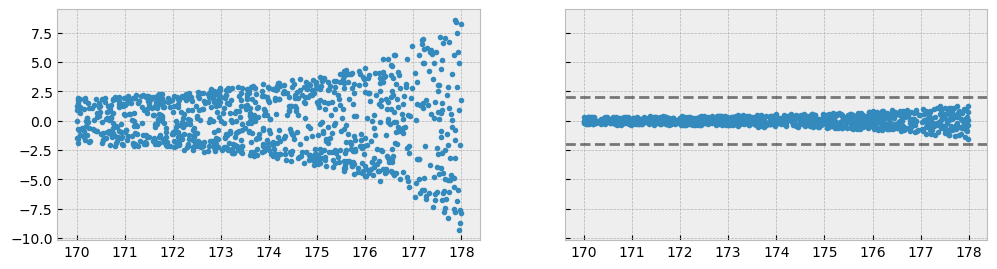

In [10]:
plot_case_results(dat)

In [11]:
dat177 = run_cases(1000, min_pitch=177.99)

In [13]:
print(np.max(np.abs((dat177["onr_accurate"] - dat177["off_nom_roll"]))))

1.6684817399488878
